In [1]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path('../..')))
from project_utils import *

from nilearn.plotting import plot_connectome
# ho_labels = pd.read_excel(f'{parcellation_dir}/HarvardOxford/HavardOxford_labels.xlsx')
# shen_df = read_excel(f'{parcellation_dir}/Shen_parcellations/Shen_368/Shen_368_labels2.xlsx')

Project directory: /Users/matthew/Dropbox/Projects/SNT-CUD


### Get FCs

In [2]:
# get fc files
corr_kind = 'correlation'
fc_fnames = glob.glob(f'{fc_dir}/*roi_{corr_kind}_z.xlsx')
sub_info  = get_fname_ids(fc_fnames, exclude=False)

n=75


In [3]:
# get roi and fc ut labels -- maybe just run the whole thing and then subset...
atlas = 'HO'
atlas_regions = [f for f in read_excel(sub_info['fname'][0], index_col=0).columns if atlas in f] 
atlas_fcs     = symm_mat_labels_to_vec(atlas_regions, upper=True)
print(f'{len(atlas_regions)} selected regions')

# combine fc files
fc_fname = f'{fc_dir}/summary/{atlas}_n{len(fc_fnames)}_{corr_kind}_z.csv'

if os.path.exists(fc_fname):
    
    print('Already collected FCs - loading file...')
    fc_df = pd.read_csv(fc_fname)
    
else:
    
    print('Collecting FCs...', end=" ")
    dfs = [] 
    for i, fname in enumerate(sub_info['fname']):
        fcs   = read_excel(fname, index_col=0) # function to speed reading big excel sheets... but doesnt work on desktop...            
        ut_fc = symm_mat_to_ut_vec(fcs.loc[atlas_regions, atlas_regions].values).reshape(1,-1)
        dfs.append(pd.DataFrame(ut_fc, columns=atlas_fcs)) 
        
    fc_df = pd.concat(dfs) # shape = (subs, fcs)
    fc_df.insert(0, 'sub_id', sub_info['sub_id'].values)
    fc_df.insert(1, 'dx', sub_info['dx'].values)
    fc_df.to_csv(fc_fname, index=False) # to csv
    print('Done')
    
fc_df = fc_df.merge(beh_df, on=['sub_id', 'dx'])
display(fc_df.head(3))

117 selected regions
Already collected FCs - loading file...


,sub_id,dx,HO_Cortl_LeftFrontalPole_and_HO_Cortl_RightFrontalPole,HO_Cortl_LeftFrontalPole_and_HO_Cortl_LeftInsularCortex,HO_Cortl_LeftFrontalPole_and_HO_Cortl_RightInsularCortex,HO_Cortl_LeftFrontalPole_and_HO_Cortl_LeftSuperiorFrontalGyrus,HO_Cortl_LeftFrontalPole_and_HO_Cortl_RightSuperiorFrontalGyrus,HO_Cortl_LeftFrontalPole_and_HO_Cortl_LeftMiddleFrontalGyrus,HO_Cortl_LeftFrontalPole_and_HO_Cortl_RightMiddleFrontalGyrus,HO_Cortl_LeftFrontalPole_and_HO_Cortl_LeftInferiorFrontalGyrusparstriangularis,...,dots_affil_first,dots_power_first,dots_affil_powerful,dots_power_powerful,dots_affil_boss,dots_power_boss,dots_affil_neutral,dots_power_neutral,dots_affil_assistant,dots_power_assistant
0,18001,HC,1.299181,0.553551,0.493991,1.028152,0.918436,0.923564,0.898479,0.973894,...,0.115716,-0.273992,0.329903,0.599444,0.354937,0.905424,-0.379416,0.273992,0.021140,0.176634
1,18002,HC,0.705432,0.595586,0.575472,0.685489,0.641892,0.637663,0.676701,0.631600,...,-0.569202,0.398887,-0.513544,0.881262,-0.565492,0.684601,-0.584045,0.565863,-0.569202,0.469388
2,18003,HC,0.988709,0.466612,0.482810,0.714388,0.572877,0.863992,0.465488,0.585510,...,0.885343,-0.150278,-0.053432,0.636364,0.228571,0.413729,-0.135065,-0.005566,0.321336,-0.142857


In [4]:
# define some networks
# -- ~regions correspnding to hierarchy network from 2021 meta-analysis
apriori_networks = {'SocHierLi2021': {'regions': ['FrontalMedialCortex','MiddleFrontalGyrus',
                                                  'Insular','Hippocampus','Amygdala','Precuneous',
                                                  'Caudate','Putamen','Accumbens','FusiformGyrus'],
                                      'peaks': [[],[],[]]}}

regions_, fcs_ = get_fc_labels(apriori_networks['SocHierLi2021']['regions'], fc_df)

# plot the brain...? eg, load the atlas nifti, find the index, plot
# regions_ = atlas_regions
# fcs_ = atlas_fcs

number of regions found = 20
number of func conn found = 190


# Correlation differences

Gr1 n=34, Gr2 n=29
max r_z diff=0.15, min r_z diff=1e-05
Gr1 n=32, Gr2 n=31
max r_z diff=0.14, min r_z diff=0.00017
Gr1 n=15, Gr2 n=14
max r_z diff=0.194, min r_z diff=0.00011
Gr1 n=15, Gr2 n=14
max r_z diff=0.182, min r_z diff=0.00051


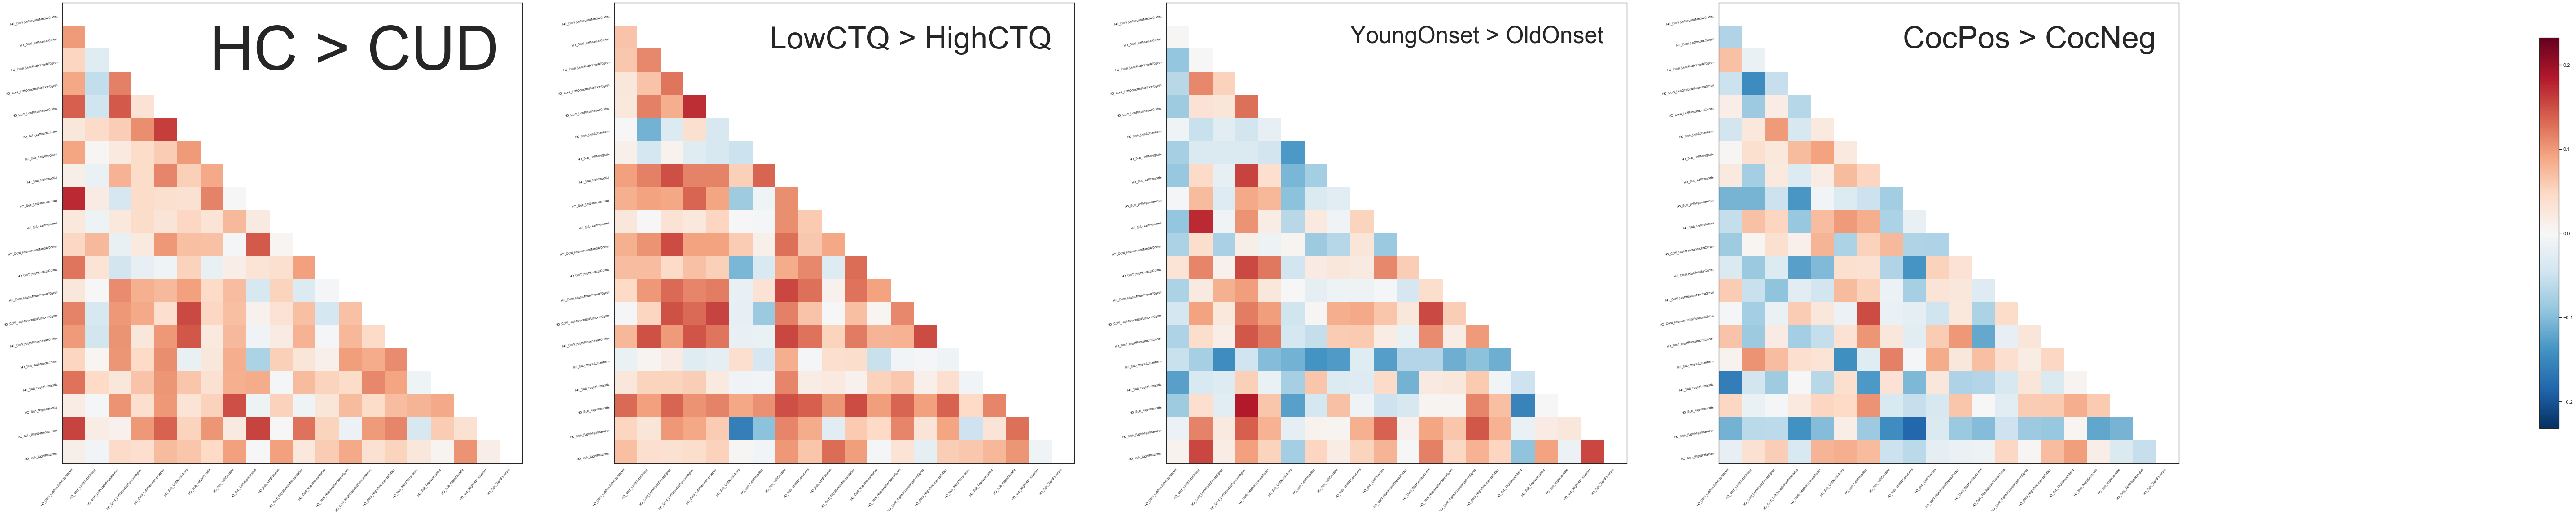

In [41]:
fc_df_ = fc_df[(fc_df.memory_incl == 1) & (fc_df.other_incl == 1)] # all included subjs
cud_df = fc_df_[fc_df_['dx'] == 'CD']  # CUD included subjs

# cud + hc
ctq = ((fc_df_['ctq_total_score_2'] > np.median(fc_df_['ctq_total_score_2'])) * 1).values # high ctq == 1
dx  = ((fc_df_['dx'] == 'CD') * 1).values # cd == 1
sex = ((fc_df_['sex'] == 'female') * 1).values

# cud only
older   = ((cud_df['coc_age_1st_use'] > np.nanmedian(cud_df['coc_age_1st_use'])) * 1).values
coc_pos = cud_df['mri_utox___coc'].values

# comparisons in a dictionary
comparisons = {'HC > CUD':[fc_df_, dx], 
               'LowCTQ > HighCTQ':[fc_df_, ctq],
               'YoungOnset > OldOnset':[cud_df, older],
               'CocPos > CocNeg':[cud_df, coc_pos]}

fig, axs = plt.subplots(1, len(comparisons), figsize=(25*len(comparisons), 20))
for i, (comp_name, values) in enumerate(comparisons.items()):
    
    df = values[0]
    y  = values[1]
        
    # by group
    gr1_corrs = df[y == 0][fcs_]
    gr2_corrs = df[y == 1][fcs_]
    print(f'Gr1 n={len(gr1_corrs)}, Gr2 n={len(gr2_corrs)}')
    
    # average correlation diffs
    diff     = ut_vec_to_symm_mat(np.mean(gr1_corrs, 0)) - ut_vec_to_symm_mat(np.mean(gr2_corrs, 0))
    max_diff = np.round(np.max(np.abs(diff)), 3)
    min_diff = np.round(np.min(np.abs(symm_mat_to_ut_vec(diff))), 5)
    print(f'max r_z diff={max_diff}, min r_z diff={min_diff}') # max & min diff

    # sort left & right together
    fc_ = pd.DataFrame(diff, index=[regions_], columns=[regions_])
    regions_ = sorted(regions_) # alphabetical
    regions_sorted = [r for r in regions_ if 'Left' in r] + [r for r in regions_ if 'Right' in r] # hemisphere
    
    # plot
    if i == len(comparisons)-1: colorbar = True
    else:                       colorbar = False
    nil.plotting.plot_matrix(fc_.loc[regions_sorted, regions_sorted], # np.tril(diff, k=-1)
                             tri='lower', reorder=False,
                             title=comp_name, 
                             labels=regions_sorted, colorbar=colorbar,
                             vmin=-(max_diff + 0.05), vmax=max_diff + 0.05,
                             axes=axs[i])
    
    ## plotting.plot_connectome(mean_correlations_adhd, coords,
    ##                          edge_threshold="80%", title='Correlations')

    # corr_df = corr_df.merge(df, on=['sub_id', 'dx'])

# OLS differences

In [90]:
matrices = {'dx[T.HC]':          {'p_neglog10':[], 'beta':[]},
            'ctq_total_score_2': {'p_neglog10':[], 'beta':[]}}

res_df = pd.DataFrame(columns=['n', 'fc_region1', 'fc_region2', 
                               'variable', 'pvalue', 'beta'])
for fc in fcs_:

    res, ols = run_ols(['dx', 'ctq_total_score_2'], fc, fc_df_, covariates=['age_years', 'sex', 'asi_education', 'fd_mean'])
     
    for x in ['dx[T.HC]', 'ctq_total_score_2']:
        p = np.round(res[f'{x}_pvalue'].values[0], 4)
        b = np.round(res[f'{x}_beta'].values[0], 3)
        
        matrices[x]['p_neglog10'].append(-np.log10(p))
        matrices[x]['beta'].append(b)
        
        if p < 0.05: 
            res_df.loc[len(res_df) + 1, :] = [len(res_df), fc.split('_and_')[0], fc.split('_and_')[1], x, p, b]

display(res_df)

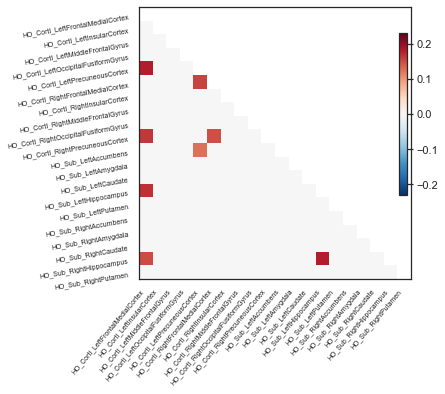

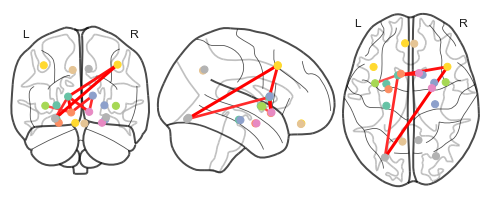

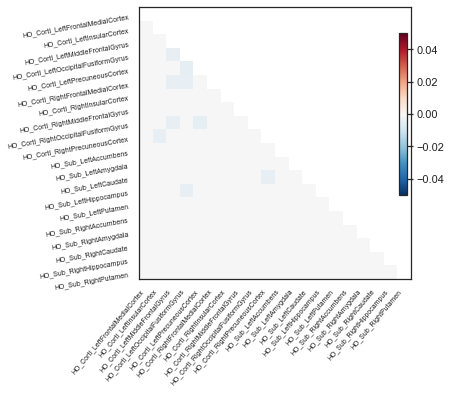

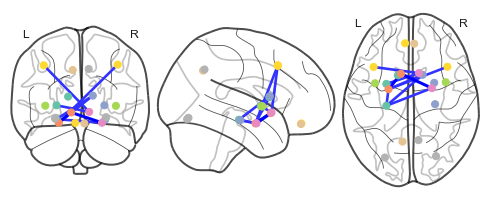

In [216]:
ho_labels_ = ho_labels[ho_labels['Region_name'].isin(regions_)]
centers    = ho_labels_[['MNI_X', 'MNI_Y', 'MNI_Z']].values

for x in ['dx[T.HC]', 'ctq_total_score_2']:
    ps_symm    = ut_vec_to_symm_mat(np.array(matrices[x]['p_neglog10']))
    betas_symm = ut_vec_to_symm_mat(np.array(matrices[x]['beta']))
    betas_symm = betas_symm * (ps_symm > -np.log10(0.05)) * 1
    max_beta   = np.max(betas_symm)

    nil.plotting.plot_matrix(betas_symm, 
                             tri='lower', reorder=False,
                             title=None, 
                             labels=regions_,
                             colorbar=colorbar,
                             vmin=-(max_beta + 0.05), vmax=max_beta + 0.05)
                             #axes=axs[i])
    plt.show()
    
    nil.plotting.plot_connectome(betas_symm, centers, display_mode='ortho',
                             node_color='auto', node_size=50, 
                             # edge_cmap=<matplotlib.colors.LinearSegmentedColormap object>, 
                             edge_vmin=None, edge_vmax=None, edge_threshold=None, 
                             output_file=None, figure=None, 
                             axes=None, title=None, annotate=True, black_bg=False, 
                             alpha=0.7, edge_kwargs=None, node_kwargs=None, colorbar=False)
    plt.show()

# better comparisons...
- t-test against 0 for f matrices? 
- symmetrical matrices w/ arbitrary statistical functions 

In [238]:
# pass in a kwargs variable for eg popmean
df   = cud_df[fcs_]
res = [scipy.stats.ttest_1samp(df[col], popmean=0)[:] for col in df] # (t,p)

TypeError: ttest_1samp() missing 1 required positional argument: 'a'

[(6.597746232765707, 3.7222131935163286e-07),
 (7.179822226134867, 8.173248717273062e-08),
 (6.106531095126009, 1.3746654323751453e-06),
 (7.806794567697677, 1.669494442128794e-08),
 (14.208663611560127, 2.510351591427928e-14),
 (5.734421373879908, 3.7484478320064826e-06),
 (6.734154208093964, 2.6005117102397894e-07),
 (5.220891320467232, 1.5163881413554148e-05),
 (7.180771231384833, 8.153327609224442e-08),
 (6.9685005040824, 1.4110019948550255e-07),
 (5.920499972740943, 2.2669990881892866e-06),
 (7.873480472868529, 1.4140754544720886e-08),
 (6.647111088992226, 3.2684510895412293e-07),
 (7.469284308879591, 3.902166210423257e-08),
 (5.337344730154851, 1.1034738988912152e-05),
 (4.9573823726709545, 3.116112325471712e-05),
 (6.568079678413012, 4.0251634347535045e-07),
 (7.569332990855356, 3.029418317352976e-08),
 (6.7987024536175955, 2.1961403076273075e-07),
 (11.829757776396406, 2.0853365308994914e-12),
 (9.761033032623466, 1.6371743285483233e-10),
 (12.027963047515346, 1.410103953773885

In [236]:
n, c = df.shape # shape=(n, num of comparisons)
for col in df:
    df[col]

In [237]:
func(df[col])

TypeError: ttest_1samp() missing 1 required positional argument: 'popmean'

### Hippocampal long-axis

In [15]:
# # all apriori
# apriori_labels    = [f for f in fcs_.columns if 'Apriori' in f]
# apriori_ut_labels = symm_mat_labels_to_vec(apriori_labels)

# # get correlations
# fname = f'{fc_dir}/Apriori_fc_n{len(fnames)}.xlsx'
# if os.path.exists(fname):
#     print('Already computed')
#     hpc_df = read_excel(fname)
# else:
#     print('Computing')
#     hpc_dfs = [] 
#     for i,fname in enumerate(fnames):
#         fcs = read_excel(fname, index_col=0) # function to speed reading big excel sheets            
#         ut_fc = symm_mat_to_ut_vec(fcs.loc[apriori_labels, apriori_labels].values).reshape(1,-1)
#         hpc_dfs.append(pd.DataFrame(ut_fc, columns=apriori_ut_labels)) # shape = (subs, fcs)
#     hpc_df = pd.concat(hpc_dfs)
#     hpc_df.insert(0, 'sub_id', sub_info['sub_id'].values)
#     hpc_df.insert(1, 'dx', sub_info['dx'].values)
#     hpc_df.to_excel(f'{fc_dir}/Apriori_fc_n{len(fnames)}.xlsx')
# hpc_df = hpc_df.merge(df, on=['sub_id', 'dx'])

In [16]:
# # specified fewer
# labels_ = ['Apriori_LIFG_radius8','Apriori_LHPC_ant','Apriori_LHPC_post','Apriori_LHPC_mid']
# # 'Apriori_RIFG_radius8','Apriori_RHPC_ant','Apriori_RHPC_post','Apriori_RHPC_mid'

# ut_labels_ = check_labels(symm_mat_labels_to_vec(labels_), hpc_df)
# # ut_labels_ = ['Apriori_LIFG_radius8_and_Apriori_LHPC_ant', 
# #               'Apriori_LIFG_radius8_and_Apriori_LHPC_post',
# #               'Apriori_LIFG_radius8_and_Apriori_LHPC_mid']

# # mni coordinates
# roi_coords = {'Apriori_LHPC_ant':[-22,-3,-23], 'Apriori_LHPC_mid':[-22,-22,-15], 'Apriori_LHPC_post':[-22,-32,-6],
#               'Apriori_RHPC_ant':[22,-3,-23], 'Apriori_RHPC_mid':[22,-22,-15], 'Apriori_RHPC_post':[22,-32,-6],
#               'Apriori_LIFG_radius8':[-45,41,-2], 'Apriori_RIFG_radius8':[51,50,1]}
# coords = [roi_coords[l] for l in labels_]

# # get correlation diff
# c_df = pd.melt(hpc_df, id_vars=['sub_id','dx'], value_vars=ut_labels_, 
#                var_name='fc', value_name='z',
#                ignore_index=False)
# display(c_df.head(3))

# fc = hpc_df[['dx'] + list(ut_labels_)]
# cd = ut_vec_to_symm_mat(np.mean(fc[fc['dx']=='CD'].iloc[:,1:],0))
# hc = ut_vec_to_symm_mat(np.mean(fc[fc['dx']=='HC'].iloc[:,1:],0))
# fc_diff = hc-cd

In [17]:
# # correlation between r ifg & diff subsections of left hpc: post->mid->ant
# # -- might want to break down by affil & power trials...

# color_list = plot.get_cmap_colors(plt.get_cmap('magma', 6))
# pal = plot.make_palette([color_list[1], color_list[2], color_list[4]])

# fig = plt.figure(figsize=(12, 9))
# gs  = plot.GridSpec(1, 2, width_ratios=[3, 3])
# ax1 = fig.add_subplot(gs[0])
# ax2 = fig.add_subplot(gs[1])

# ## ax1: plot individual subjects
# bp_labels = ['Apriori_LIFG_radius8_and_Apriori_LHPC_post',
#              'Apriori_LIFG_radius8_and_Apriori_LHPC_mid',
#              'Apriori_LIFG_radius8_and_Apriori_LHPC_ant']

# sns.barplot(x='dx', y='z', hue='fc', data=c_df,  hue_order=bp_labels, ax=ax1,
#             ec='k', linewidth=1, palette="magma", saturation=1)
# sns.stripplot(x='dx', y='z', hue='fc', data=c_df, hue_order=bp_labels, dodge=True, ax=ax1,
#               ec='k', linewidth=1, palette="magma", alpha=0.75)
# ax1.axhline(y=0, linewidth=1, color='k')
# ax1.set_ylim(-.2, .33)
# h, l = ax1.get_legend_handles_labels()
# ax1.legend(h[len(bp_labels):], l[len(bp_labels):], 
#            title='FC w/ L-IFG', # ['LHPC Ant', 'LHPC Mid', 'LHPC post']
#            bbox_to_anchor=(1.85, 1), loc='upper right')

# ## ax2: plot connectome
# nil.plotting.plot_connectome(fc_diff, coords, display_mode='x',
#                              node_size=500, #node_color=['grey'] + [color_list[4], color_list[1], color_list[2]], 
#                              colorbar=False, annotate=False, axes=ax2) # edge_threshold="80%" <- use to threshold if dense..
# plt.show()

### Laterality

In [217]:
# left_regions_,  left_fcs_  = get_fc_labels(['Left'], fc_df_[fcs_])
# right_regions_, right_fcs_ = get_fc_labels(['Right'], fc_df_[fcs_])
# assert len(left_regions_) == len(right_regions_), 'Number of left != number of right'

# for hemi_fcs in [left_fcs_, right_fcs_]:

#     hemi    = fc_df_[['dx'] + hemi_fcs]
#     hc_hemi = hemi[hemi['dx']=='HC'].iloc[:,1:]
#     cd_hemi = hemi[hemi['dx']=='CD'].iloc[:,1:]

#     print(scipy.stats.ttest_ind(np.mean(hc_hemi,1), np.mean(cd_hemi,1)))
    
# # then look at the hemispheric difference...
# # laterality within subjects
# left_v_right = np.mean(fc_df_[left_fcs_],1)  - np.mean(fc_df_[right_fcs_],1)
# right_v_left = np.mean(fc_df_[right_fcs_],1) - np.mean(fc_df_[left_fcs_],1)
# cd = left_v_right[(fc_df_['dx'] == 'CD')]
# hc = left_v_right[(fc_df_['dx'] == 'HC')]
# print(scipy.stats.ttest_ind(cd, hc))

## Plot 4 quadrants: CD+low_trama, CD+high_trama, HC+low_trama, HC+high_trama,

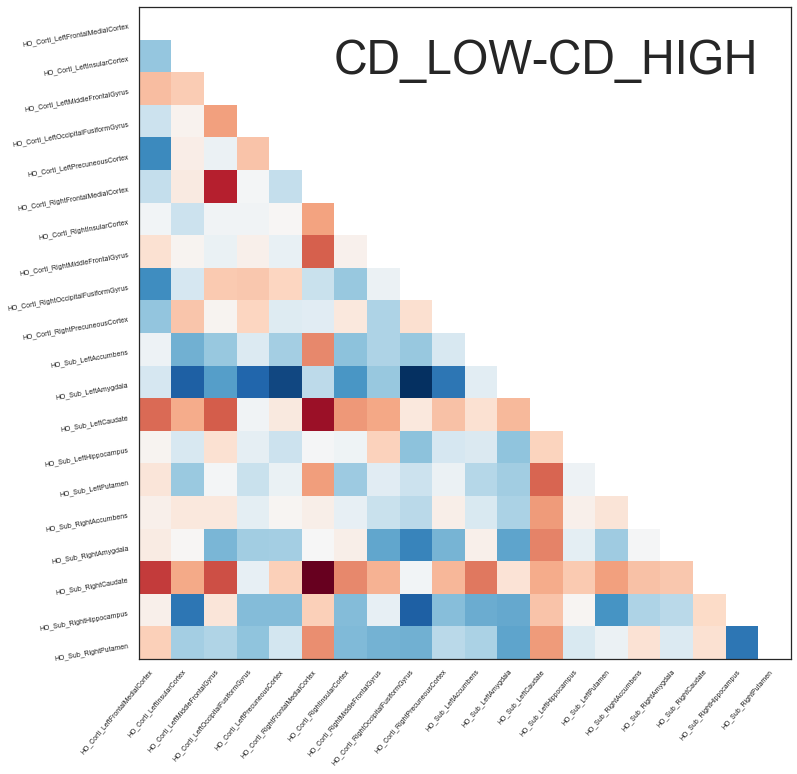

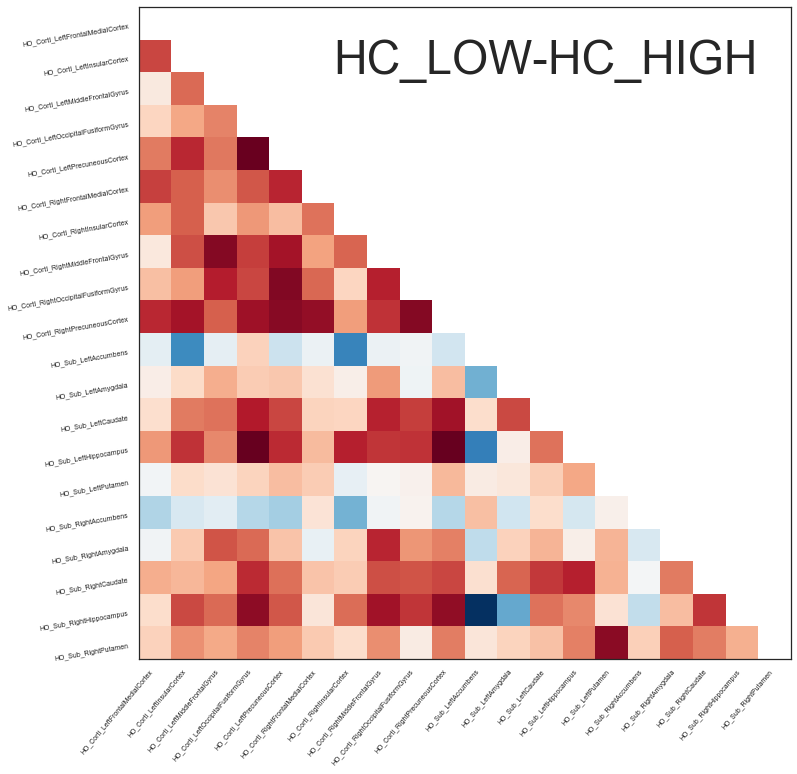

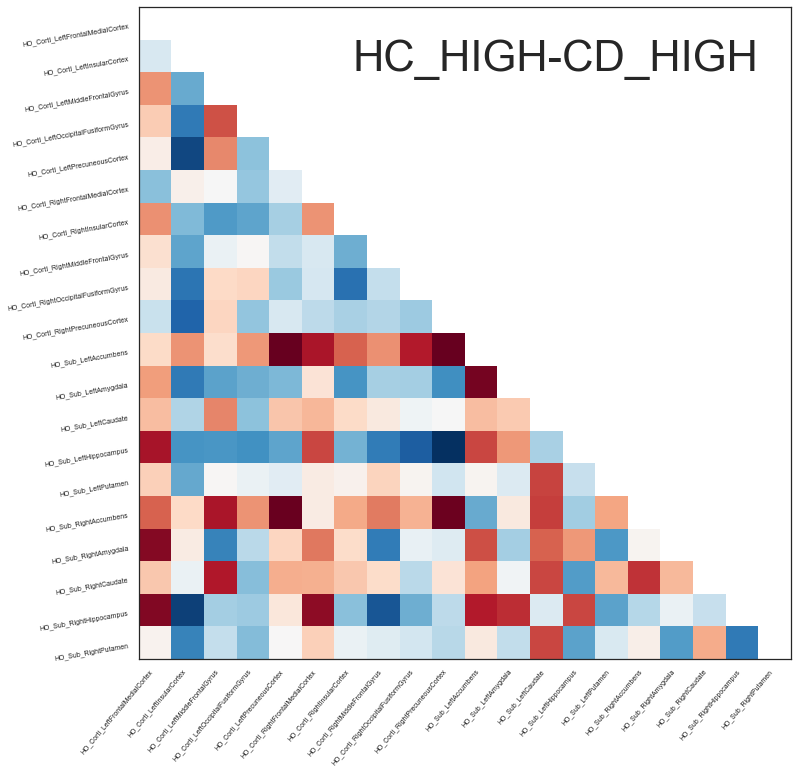

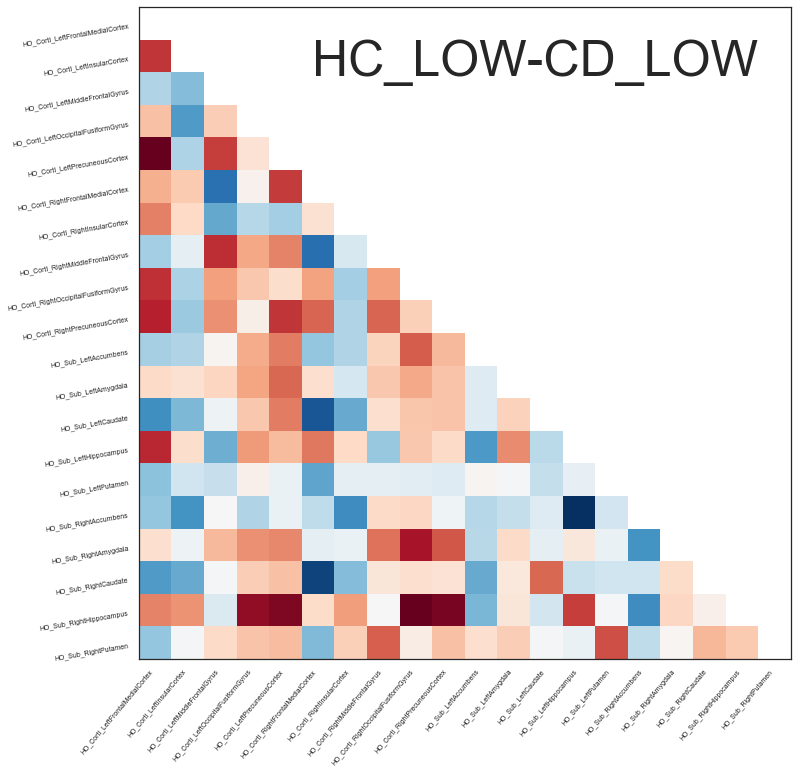

In [42]:
cd_hi = (dx == 1) & (ctq == 1)
cd_lo = (dx == 1) & (ctq == 0)
hc_hi = (dx == 0) & (ctq == 1)
hc_lo = (dx == 0) & (ctq == 0)

comps = {'CD_LOW-CD_HIGH':[cd_lo, cd_hi], # diff between trauma within cd
         'HC_LOW-HC_HIGH':[hc_lo, hc_hi], # diff between trauma within hc
         'HC_HIGH-CD_HIGH':[hc_hi, cd_hi], # diff between dx within hi trauma
         'HC_LOW-CD_LOW':[hc_lo, cd_lo]} # diff between dx within lo trauma

# fig, axs = plt.subplots(4,1, figsize=(20, 0))
for c, (comp_name, comp) in enumerate(comps.items()):
    corrs1 = np.mean(fc_df_[comp[0]][fcs_], 0).values
    corrs2 = np.mean(fc_df_[comp[1]][fcs_], 0).values
    corr_diff = ut_vec_to_symm_mat(corrs1-corrs2)
    nil.plotting.plot_matrix(corr_diff, title=comp_name, figure=(15,12),
                             tri='lower', reorder=False,
                             labels=regions_, colorbar=False)
    plt.show()

n=[0.63807053 0.21902513 0.18480063 ... 0.3046727  0.05498542 0.0697734 ]
n=[0.56152948 0.25230956 0.27179562 ... 0.30125296 0.13169359 0.09350852]
n=[0.50033275 0.20305307 0.11379612 ... 0.22461659 0.10484118 0.10229277]
n=[0.59801727 0.22096704 0.23606281 ... 0.29454746 0.14466614 0.06623318]


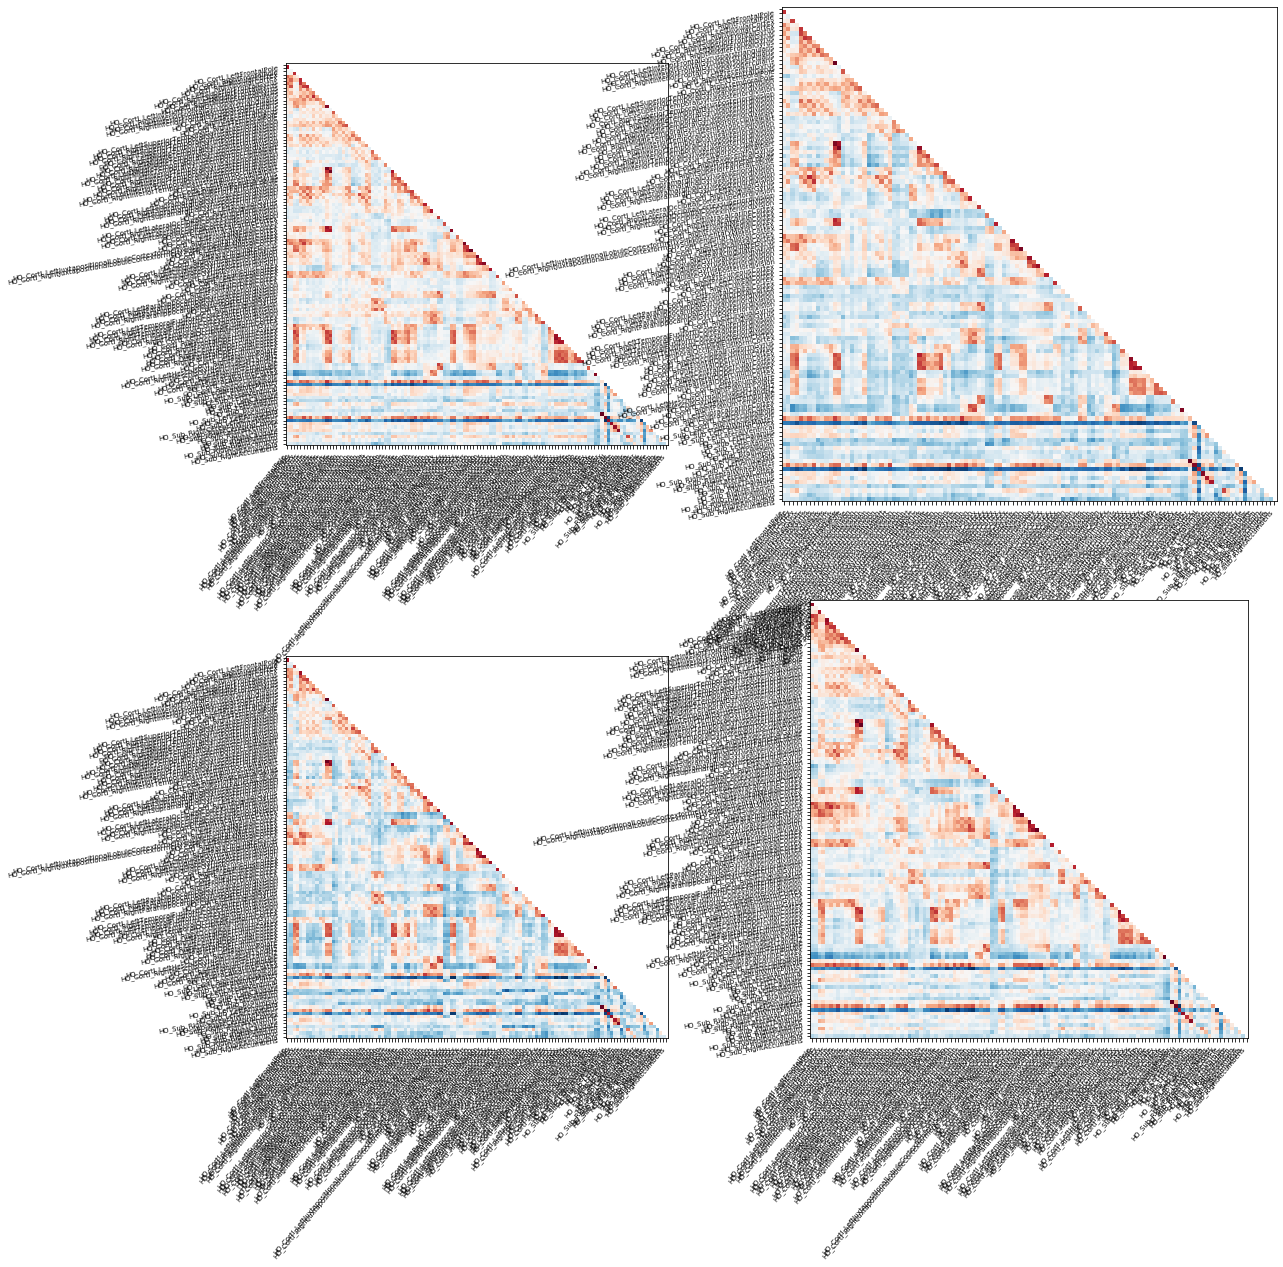

In [191]:
# fig, axs = plt.subplots(2,2, figsize=(20, 20))
# for d in range(0,2):
#     for c in range(0,2):

#         corrs    = fc_df_[(dx == d) & (ctq == c)][fcs_]
#         corrs    = np.mean(corrs, 0).values
#         corr_mat = ut_vec_to_symm_mat(corrs)
        
#         print(f'n={len(corrs)}')
#         nil.plotting.plot_matrix(corr_mat,
#                                  tri='lower', reorder=False,
#                                  labels=regions_, colorbar=False,
# #                                  vmin=-(max_diff + 0.05), vmax=max_diff + 0.05,
#                                  axes=axs[d,c])
        
# # TO DO: maybe isolate key regions & then plot the differences between groups somehow

In [45]:
X = fc_df_[fcs_].values
y = dx
if np.mean(y) < 0.5: chance = 1-np.mean(y)
else:                chance = np.mean(y)
    
print(f'X has shape:{X.shape}')
print(f'Chance={np.round(chance,3)}')
print(f'HC n={np.sum(y==0)}, CD n={np.sum(y==1)}\n')

# grid search
rs = 50
parameters = {'gaussian':{},
              'lr':{'C':[1,0.5,0.25,0.1,0.05,0.01,0.0001],
                    'solver':['saga','liblinear'],
                    'penalty':['l1','l2','elasticnet']},
              'svc':{'C':[0.1,0.01,0.0001],
                     'kernel':['linear', 'poly', 'rbf', 'sigmoid']},
#               'mlp':{'hidden_layer_sizes':[(20,),(20,10),(30,)], 
#                      'alpha':[0.01,0.001,0.00001]},
              'knn':{'n_neighbors':[3,4,5,6,7]},
              'tree':{'criterion':['gini', 'entropy', 'log_loss']}}
classifiers = {'gaussian':GaussianNB(),
               'lr':LogisticRegression(),
               'svc':SVC(random_state=rs),
#                'mlp':MLPClassifier(random_state=22),
               'knn':KNeighborsClassifier(weights='distance'),
               'tree':DecisionTreeClassifier(random_state=rs)}
gs = ClassifierGridSearch(classifiers, parameters)
gs.search(X, y)
gs_df = gs.summary()
gs_df.head(10)

# other classifier results...
# ROC

X has shape:(63, 190)
Chance=0.54
HC n=34, CD n=29

Running GridSearchCV for gaussian.
Running GridSearchCV for lr.
Running GridSearchCV for svc.
Running GridSearchCV for knn.
Running GridSearchCV for tree.
Done.


,estimator,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score
0,tree,0.002884,0.000089,0.000458,0.000165,{'criterion': 'gini'},0.615385,0.692308,0.384615,0.583333,0.583333,0.571795,0.101711
1,lr,0.000792,0.000046,0.000373,0.000126,"{'C': 0.01, 'penalty': 'l2', 'solver': 'liblin...",0.538462,0.538462,0.538462,0.583333,0.500000,0.539744,0.026399
2,svc,0.001132,0.000113,0.000471,0.000040,"{'C': 0.01, 'kernel': 'rbf'}",0.538462,0.538462,0.538462,0.583333,0.500000,0.539744,0.026399
3,lr,0.011385,0.002810,0.000457,0.000101,"{'C': 0.0001, 'penalty': 'l2', 'solver': 'saga'}",0.538462,0.538462,0.538462,0.583333,0.500000,0.539744,0.026399
4,lr,0.000692,0.000093,0.000302,0.000030,"{'C': 0.01, 'penalty': 'l1', 'solver': 'liblin...",0.538462,0.538462,0.538462,0.583333,0.500000,0.539744,0.026399
5,lr,0.001057,0.000203,0.000504,0.000138,"{'C': 0.0001, 'penalty': 'l2', 'solver': 'libl...",0.538462,0.538462,0.538462,0.583333,0.500000,0.539744,0.026399
6,svc,0.001486,0.000339,0.000602,0.000091,"{'C': 0.1, 'kernel': 'rbf'}",0.538462,0.538462,0.538462,0.583333,0.500000,0.539744,0.026399
7,svc,0.001241,0.000083,0.000439,0.000038,"{'C': 0.1, 'kernel': 'sigmoid'}",0.538462,0.538462,0.538462,0.583333,0.500000,0.539744,0.026399
8,lr,0.000718,0.000194,0.000289,0.000074,"{'C': 0.05, 'penalty': 'l1', 'solver': 'liblin...",0.538462,0.538462,0.538462,0.583333,0.500000,0.539744,0.026399
9,lr,0.000534,0.000029,0.000237,0.000004,"{'C': 0.1, 'penalty': 'l1', 'solver': 'libline...",0.538462,0.538462,0.538462,0.583333,0.500000,0.539744,0.026399


# Classification: best acc is ~67-71% against ~50-55% chance
- classify CD/HC and high/low CTQ: are the predictive patterns similar or different?
- show the classifiers arent learning the same features: e.g., w/ cross-decoding
- use non-accuracy metrics

https://nilearn.github.io/dev/auto_examples/07_advanced/plot_age_group_prediction_cross_val.html

In [111]:
# for c in range(0,2):
#     for d in range(0,2):
#         print(np.sum((dx == d) & (ctq == c)))

# Network analysis
https://dartbrains.org/content/Connectivity.html

not sure abt the graph measures were getting... weird, narrow values

In [196]:
# graph_files = glob.glob(f'{lsa_dir}/graphs/*HO_correlation*')
# print(f'Found {len(graph_files)} graph pickles')

# network_df = pd.DataFrame(columns=['sub_id', 'L-HPC_eig-centrality'])
# for g, graph_file in enumerate(graph_files):
#     graph_obj = load_pickle(graph_file)
#     lhpc      = graph_obj['graph'].graph.nodes['HO_Sub_LeftHippocampus']['eigenvector_centrality']
#     sub_id    = graph_file.split('/')[-1].split('_')[0]
#     network_df.loc[g,:] = [sub_id, lhpc]
# network_df

In [ ]:
# a = nlt.Adjacency(np.abs(diff), matrix_type='similarity')
# a_thr = a.threshold(upper=0.1, binarize=True) # where to binarize - depends on the correlation matrix
# a_thr.plot()

# # network graph
# G   = a_thr.to_graph()
# pos = nx.kamada_kawai_layout(G) # pos???
# node_and_degree = G.degree()

# # plot
# plt.figure(figsize=(15, 15))
# nx.draw_networkx_edges(G, pos, width=3, alpha=.2)
# nx.draw_networkx_labels(G, pos, font_size=14, font_color='darkslategray')
# nx.draw_networkx_nodes(G, pos, 
#                        nodelist=list(dict(node_and_degree).keys()),
#                        node_size=[x[1]*100 for x in node_and_degree],
#                        node_color=list(dict(node_and_degree).values()),
#                        cmap=plt.cm.Reds_r, edgecolors='darkslategray', alpha=1, linewidths=2)

In [ ]:
## across subjects: calculate properties
# roi_properties = {}
# for roi in rois_atlas: 
#     roi_dfs = []
#     for key, data in network_data.items():
#         df = pd.DataFrame.from_dict(data['graph'].graph.nodes[roi], orient='index').T
#         df.index = [key]
#         roi_dfs.append(df)
#     roi_properties[roi] = pd.concat(roi_dfs)
            
# # # calculate the mean and std
# # roi_dc_df = pd.DataFrame(columns=['roi','dc_avg','dc_std'])
# # for i, (roi, dcs) in enumerate(roi_dc.items()):   
# #     roi_dc_df.loc[i, :] = [roi, np.mean(dcs), np.std(dcs)]

In [ ]:
# ## run community detection on the adjacency matrices
# communities = {}
# for key, data in network_data.items():
#     communities[key] = data['graph'].find_communities(levels=7)

# Correlate w/ self-report variables

In [23]:
# [c for c in fc_df.columns if 'mri' in c]

In [195]:
sr_corr_df = pd.DataFrame(columns=['n', 'fc_region1', 'fc_region2', 'variable', 'pvalue', 'beta'])
for sr_col in ['ctq_total_score_2', 
               'sni_num_ppl', 'lsas_social_interaction_fear_subscale', 
               'cssa_total_mri', 'coc_age_1st_use', 'coc_days_last_use', 'mri_utox___coc']:
        
    X_labels = [sr_col]
                
    if 'coc' in sr_col or 'cssa' in sr_col: # ensure its only CUDs
        mask = np.isfinite(fc_df_[sr_col]) & (fc_df_['dx'] == 'CD')
    else: # control for diagnosis if it's not already a cocaine variable
        X_labels.append('C(dx)')
        X_labels.append('C(dx)*' + sr_col)
        mask = np.isfinite(fc_df_[sr_col])
    n = np.sum(mask)
                   
    for fc in fcs_:
        
        # if 'Hippocampus' in fc_col or 'Precun' in fc_col or 'Cingulate' in fc_col:
        # to speed up, filter on bivariate correlation
        _, cor_p = scipy.stats.pearsonr(fc_df_[fc][mask], fc_df_[fc][mask])
        if cor_p < 0.05: 
            
            res_df, _ = run_ols(X_labels, fc, fc_df_[mask], covariates=['age_years', 'sex', 'asi_education', 'fd_mean'])
            ols_p     = np.round(res_df[sr_col + '_pvalue'].values[0],4)
            ols_b     = np.round(res_df[sr_col + '_beta'].values[0],3)
            if ols_p < 0.01: sr_corr_df.loc[len(sr_corr_df) + 1, :] = [n, fc.split('_and_')[0], fc.split('_and_')[1], sr_col, ols_p, ols_b]

display(sr_corr_df)

,n,fc_region1,fc_region2,variable,pvalue,beta
1,63,HO_Cortl_RightFrontalMedialCortex,HO_Sub_LeftCaudate,ctq_total_score_2,0.0072,-0.007
2,63,HO_Cortl_RightFrontalMedialCortex,HO_Sub_RightCaudate,ctq_total_score_2,0.0042,-0.007
3,63,HO_Cortl_RightFrontalMedialCortex,HO_Sub_LeftAccumbens,lsas_social_interaction_fear_subscale,0.0095,-0.016
4,63,HO_Cortl_RightFrontalMedialCortex,HO_Sub_RightPutamen,lsas_social_interaction_fear_subscale,0.0086,-0.016
5,63,HO_Sub_LeftAccumbens,HO_Sub_RightCaudate,lsas_social_interaction_fear_subscale,0.0095,-0.016
6,63,HO_Sub_LeftCaudate,HO_Sub_LeftHippocampus,lsas_social_interaction_fear_subscale,0.0083,-0.016
7,63,HO_Sub_LeftCaudate,HO_Sub_LeftPutamen,lsas_social_interaction_fear_subscale,0.0056,-0.019
8,63,HO_Sub_LeftCaudate,HO_Sub_RightHippocampus,lsas_social_interaction_fear_subscale,0.0045,-0.02
9,63,HO_Sub_LeftCaudate,HO_Sub_RightPutamen,lsas_social_interaction_fear_subscale,0.005,-0.018
